<img src="images/poe_logo.png" />

# PoE Image Classification

This is a small project to test out a Convolutional Neural Network in PyTorch with a custom dataset. The CNN used is very basic, and its architecture is based on the TinyVGG architecture. The dataset used is a compilation of all items (regular and uniques) in Path of Exile, split up among their ingame base type, e.g.: Axes, Flasks, Belts, etc. The base dataset consists of 1,971 samples. The dataset size is increased by creating mirrored and slightly augmented copies of the original dataset, resulting in 5,913 total samples. A 70:30 train:test split is used, resulting in 4,116 training images and 1,797 testing images.

It's expected that certain base types will be easier to predict than others. Flasks, for example, look very alike, which should be easy for the neural network to handle. There also exist items that will guaranteed be impossible to predict correctly. One such example is the Brinerot Flag, a unique Shield:

<img src="images/brinerot_flag.png" align="left" />

With its appearance being akin to a wine bottle, it's unlikely that the model will be able to predict the correct Shield class. There are many items within Path of Exile with creative designs that make them deviate from what their base type would commonly look like. In addition, some of the item classes contain many more distinct items than others. For example, there are 139 total Gloves samples and 185 total Armour samples, but there are only 40 Quivers samples. It's also expected that Jewels and Rings might be confused at time, as they are both small and circular most of the time.

Due to these naturally occurring limitations in the dataset, it's expected that certain classes will perform much better than others, and that performance is hampered by impossible-to-predict items such as the Brinerot Flag.

## Table of Contents

- [Imports](#imports)
- [Prepare Data](#prepdata)
- [Prepare Model](#prepmodel)
- [Train Model](#trainmodel)
- [Evaluate Model](#evalmodel)
- [Conclusion](#conclusion)

## Imports <a name="imports" />

In [1]:
# Imports
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchmetrics import Accuracy, ConfusionMatrix
from torchinfo import summary
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple
from PIL import Image
import random
import os

In [2]:
# Torch & Torchvision versions
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu117
0.14.1+cu117


## Prepare Data <a name="prepdata" />

In [3]:
# Basic transform to resize only
basic_transform = transforms.Compose([
    transforms.Resize((234, 234)),
    transforms.ToTensor()
])

# Transform to create mirrored copies of images
mirror_transform = transforms.Compose([
    transforms.Resize((234, 234)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()
])

# Transform to create slightly augmented copies of images
augment_transform = transforms.Compose([
    transforms.Resize((234, 234)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [4]:
# Data directory & paths
IMAGE_PATH = Path("data/PoEFashion")
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")

In [5]:
# Train datasets
train_base = datasets.ImageFolder(root=TRAIN_DIR, transform=basic_transform)
train_mirror = datasets.ImageFolder(root=TRAIN_DIR, transform=mirror_transform)
train_augment = datasets.ImageFolder(root=TRAIN_DIR, transform=augment_transform)

# Test datasets
test_base = datasets.ImageFolder(root=TEST_DIR, transform=basic_transform)
test_mirror = datasets.ImageFolder(root=TEST_DIR, transform=mirror_transform)
test_augment = datasets.ImageFolder(root=TEST_DIR, transform=augment_transform)

In [6]:
# Lengths of the datasets
len(train_base), len(train_mirror), len(train_augment), len(test_base), len(test_mirror), len(test_augment)

(1371, 1371, 1371, 600, 600, 600)

In [7]:
# Combining train and test datasets components into full datasets
train_total = ConcatDataset([train_base, train_mirror, train_augment])
test_total = ConcatDataset([test_base, test_mirror, test_augment])

In [8]:
# Total dataset sizes
len(train_total), len(test_total)

(4113, 1800)

In [9]:
train_total.__dict__

{'datasets': [Dataset ImageFolder
      Number of datapoints: 1371
      Root location: data\PoEFashion\train
      StandardTransform
  Transform: Compose(
                 Resize(size=(234, 234), interpolation=bilinear, max_size=None, antialias=None)
                 ToTensor()
             ),
  Dataset ImageFolder
      Number of datapoints: 1371
      Root location: data\PoEFashion\train
      StandardTransform
  Transform: Compose(
                 Resize(size=(234, 234), interpolation=bilinear, max_size=None, antialias=None)
                 RandomHorizontalFlip(p=1)
                 ToTensor()
             ),
  Dataset ImageFolder
      Number of datapoints: 1371
      Root location: data\PoEFashion\train
      StandardTransform
  Transform: Compose(
                 Resize(size=(234, 234), interpolation=bilinear, max_size=None, antialias=None)
                 TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                 ToTensor(

In [10]:
test_total.__dict__

{'datasets': [Dataset ImageFolder
      Number of datapoints: 600
      Root location: data\PoEFashion\test
      StandardTransform
  Transform: Compose(
                 Resize(size=(234, 234), interpolation=bilinear, max_size=None, antialias=None)
                 ToTensor()
             ),
  Dataset ImageFolder
      Number of datapoints: 600
      Root location: data\PoEFashion\test
      StandardTransform
  Transform: Compose(
                 Resize(size=(234, 234), interpolation=bilinear, max_size=None, antialias=None)
                 RandomHorizontalFlip(p=1)
                 ToTensor()
             ),
  Dataset ImageFolder
      Number of datapoints: 600
      Root location: data\PoEFashion\test
      StandardTransform
  Transform: Compose(
                 Resize(size=(234, 234), interpolation=bilinear, max_size=None, antialias=None)
                 TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                 ToTensor()
    

In [11]:
# Creation of dataloaders and class names
train_dataloader = DataLoader(dataset=train_total, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_total, batch_size=32, num_workers=os.cpu_count(), shuffle=False)
class_names = test_base.classes

In [12]:
# Batches per dataloader
len(train_dataloader), len(test_dataloader)

(129, 57)

In [13]:
# Class names
class_names

['Amulets',
 'Armour',
 'Axes',
 'Belts',
 'Boots',
 'Bows',
 'Claws',
 'Daggers',
 'Flasks',
 'Gloves',
 'Helmets',
 'Jewels',
 'Maces',
 'Quivers',
 'Rings',
 'Sceptres',
 'Shields',
 'Staves',
 'Swords',
 'Wands']

## Prepare Model <a name="prepmodel" />

In [14]:
# Basic CNN model class based on TinyVGG
class PoEFashion(nn.Module):
    def __init__(self, in_shape: int, hidden: int, out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*625, out_features=out_shape)
        )
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

In [15]:
# Create an instance of the PoEFashion model class
model_0 = PoEFashion(in_shape=3, hidden=20, out_shape=len(class_names))

In [16]:
# Checking summary of the model
summary(model=model_0,
        input_size=[32, 3, 234, 234],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19,
        device="cpu")

Layer (type:depth-idx)                   Input Shape         Output Shape        Param #             Trainable
PoEFashion                               [32, 3, 234, 234]   [32, 20]            --                  True
├─Sequential: 1-1                        [32, 3, 234, 234]   [32, 20, 115, 115]  --                  True
│    └─Conv2d: 2-1                       [32, 3, 234, 234]   [32, 20, 232, 232]  560                 True
│    └─ReLU: 2-2                         [32, 20, 232, 232]  [32, 20, 232, 232]  --                  --
│    └─Conv2d: 2-3                       [32, 20, 232, 232]  [32, 20, 230, 230]  3,620               True
│    └─ReLU: 2-4                         [32, 20, 230, 230]  [32, 20, 230, 230]  --                  --
│    └─MaxPool2d: 2-5                    [32, 20, 230, 230]  [32, 20, 115, 115]  --                  --
├─Sequential: 1-2                        [32, 20, 115, 115]  [32, 20, 55, 55]    --                  True
│    └─Conv2d: 2-6                       [32, 2

## Train Model <a name="trainmodel" />

In [17]:
# Creating loss function, optimizer, and accuracy metric
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
metric_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [18]:
torch.manual_seed(42)
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0

    model_0.train()
    for batch, (X, y) in enumerate(train_dataloader):
        y_logits = model_0(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += metric_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    model_0.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model_0(X)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(test_logits, y)
            test_acc += metric_fn(test_pred, y)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch: 0
Train Loss: 2.23625, Train Acc: 0.31 | Test Loss: 1.78151, Test Acc: 0.48
Epoch: 1
Train Loss: 1.49547, Train Acc: 0.55 | Test Loss: 1.59689, Test Acc: 0.53
Epoch: 2
Train Loss: 1.13569, Train Acc: 0.67 | Test Loss: 1.53911, Test Acc: 0.58
Epoch: 3
Train Loss: 0.84353, Train Acc: 0.78 | Test Loss: 1.56086, Test Acc: 0.59
Epoch: 4
Train Loss: 0.62668, Train Acc: 0.84 | Test Loss: 1.70200, Test Acc: 0.62
Epoch: 5
Train Loss: 0.51087, Train Acc: 0.88 | Test Loss: 1.66646, Test Acc: 0.62
Epoch: 6
Train Loss: 0.46546, Train Acc: 0.90 | Test Loss: 1.49831, Test Acc: 0.62
Epoch: 7
Train Loss: 0.38490, Train Acc: 0.91 | Test Loss: 1.63245, Test Acc: 0.61
Epoch: 8
Train Loss: 0.37177, Train Acc: 0.92 | Test Loss: 1.50752, Test Acc: 0.62
Epoch: 9
Train Loss: 0.35609, Train Acc: 0.92 | Test Loss: 1.81094, Test Acc: 0.65


## Evaluate Model <a name="evalmodel" />

In [19]:
# Predict all test images
y_preds = []
model_0.eval()
with torch.inference_mode():  
    for batch, (X, y) in enumerate(test_dataloader):
        y_logits = model_0(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        y_preds.append(y_pred)

In [20]:
# Create tensors with all predicted labels and actual labels, respectively
y_preds_tensor = torch.cat(y_preds)
y_targets_tensor = torch.tensor(test_base.targets + test_mirror.targets + test_augment.targets)

In [21]:
# Checking tensor lengths to make sure they're equal
len(y_preds_tensor), len(y_targets_tensor)

(1800, 1800)

In [22]:
# Create a confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds_tensor, target=y_targets_tensor)

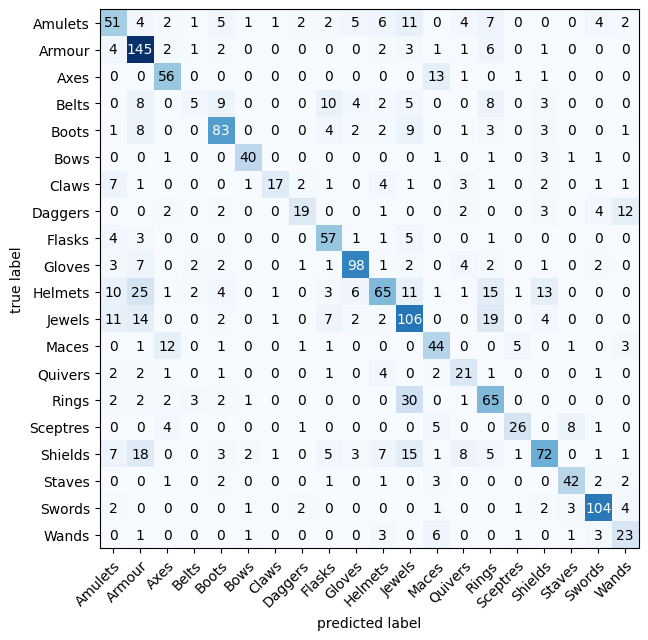

In [23]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

In [44]:
# Get a random sample of test images and their labels
test_samples, test_labels = [], []
for sample, label in random.sample(list(test_base.imgs), k=16):
    test_samples.append(sample)
    test_labels.append(label)

In [45]:
# test images and their labels
test_samples, test_labels

(['data\\PoEFashion\\test\\Shields\\Reinforced_Tower_Shield_inventory_icon.png',
  'data\\PoEFashion\\test\\Swords\\Hook_Sword_inventory_icon.png',
  'data\\PoEFashion\\test\\Quivers\\Rugged_Quiver_inventory_icon.png',
  'data\\PoEFashion\\test\\Jewels\\Hypnotic_Eye_Jewel_inventory_icon.png',
  'data\\PoEFashion\\test\\Gloves\\Ondar27s_Clasp_inventory_icon.png',
  'data\\PoEFashion\\test\\Armour\\Chains_of_Command_inventory_icon.png',
  'data\\PoEFashion\\test\\Rings\\Precursor27s_Emblem_28Endurance_and_Power_Charge29_inventory_icon.png',
  'data\\PoEFashion\\test\\Amulets\\Rotfeather_Talisman_inventory_icon.png',
  'data\\PoEFashion\\test\\Flasks\\Kiara27s_Determination_inventory_icon.png',
  'data\\PoEFashion\\test\\Rings\\Mokou27s_Embrace_inventory_icon.png',
  'data\\PoEFashion\\test\\Flasks\\Progenesis_inventory_icon.png',
  'data\\PoEFashion\\test\\Shields\\Qotra27s_Regulator_inventory_icon.png',
  'data\\PoEFashion\\test\\Wands\\Engraved_Wand_inventory_icon.png',
  'data\\PoEFas

In [46]:
# Using the model to predict the random sample
model_0.eval()
with torch.inference_mode():
    y_preds = []
    for sample in test_samples:
        img = Image.open(sample)
        t_img = basic_transform(img).unsqueeze(dim=0)
        t_img = t_img[:,:3,:,:] # Deleting Alpha channel as samples are .pngs
        y_logit = model_0(t_img)
        y_prob = torch.softmax(y_logit, dim=1)
        y_label = torch.argmax(y_prob, dim=1)
        y_preds.append(y_label)
torch.stack(y_preds).squeeze(), test_labels

(tensor([16, 18, 13, 11,  9,  1, 14,  0,  1, 14,  8, 11, 19, 14, 10, 11]),
 [16, 18, 13, 11, 9, 1, 14, 0, 8, 14, 8, 16, 19, 11, 10, 11])

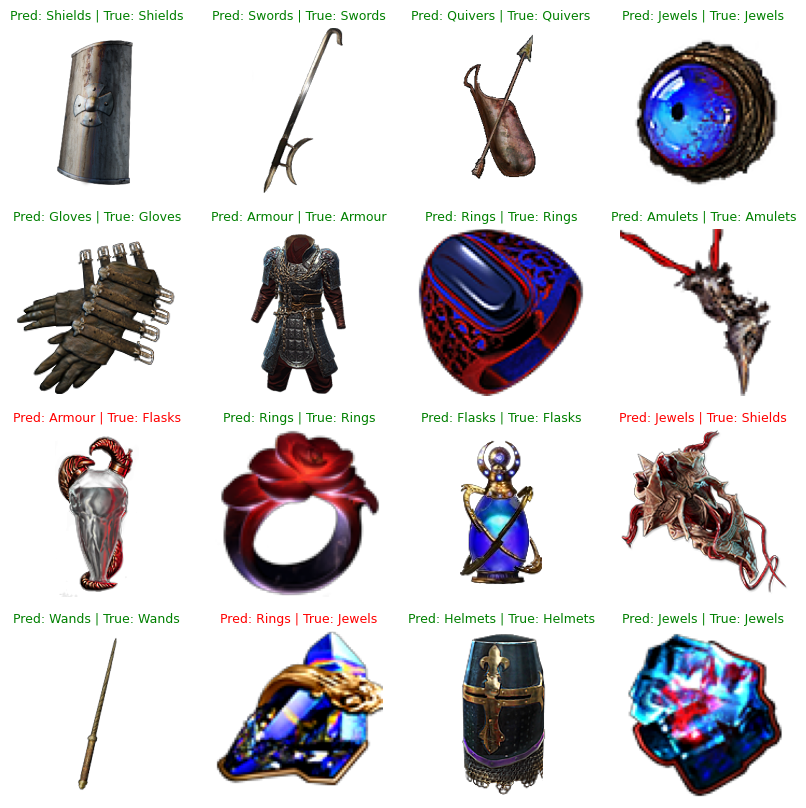

In [47]:
# Plotting the random sample's images and results
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i, sample in enumerate(test_samples):
    plt.subplot(rows, cols, i+1)
    img = Image.open(sample)
    plt.imshow(img)
    pred_label = class_names[y_preds[i]]
    actual_label = class_names[test_labels[i]]
    title = f"Pred: {pred_label} | True: {actual_label}"
    if pred_label == actual_label:
        plt.title(title, fontsize=9, c="g")
    else:
        plt.title(title, fontsize=9, c="r")
    plt.axis(False);

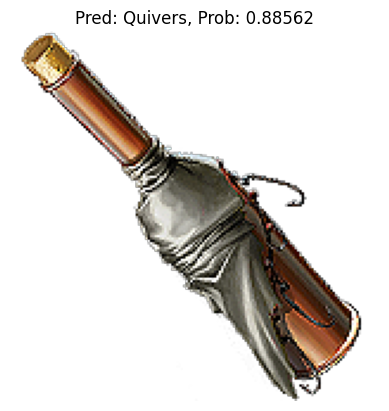

In [43]:
# Brinerot Flag test
brinerot = Path(f"{TEST_DIR}/Shields/Brinerot_Flag_inventory_icon.png")

model_0.eval()
with torch.inference_mode():
    img = Image.open(brinerot)
    t_img = basic_transform(img).unsqueeze(dim=0)
    t_img = t_img[:,:3,:,:] # Deleting Alpha channel as sample is a .png
    y_logit = model_0(t_img)
    y_prob = torch.softmax(y_logit, dim=1)
    y_label = torch.argmax(y_prob, dim=1)
    
    plt.imshow(img)
    plt.title(f"Pred: {class_names[y_label]}, Prob: {y_prob.max():.5f}")
    plt.axis(False);

## Conclusion <a name="conclusion" />

The model seems to perform very well during the training phase, and perform less well during the testing phase. This kind of overfitting can have various causes and it's worth exploring during another iteration. The total dataset size was also preemptively increased to combat this issue. The confusion matrix reveals how certain classes are easy to predict, and others that are more prone to errors. One such example is the Shields class, which regularly is confused for Jewels or Armour. Meanwhile, the Swords class is an example that is predicted almost perfectly.

The fear of certain samples being difficult to predict also came true, as seen with the Brinerot Flag test.